In [2]:
!pip install opencv-python

In [15]:
import os, numpy as np

inputdir='Inputs'
outputdir='Outputs'

if not os.path.isdir(inputdir):
  os.mkdir(inputdir)

if not os.path.isdir(outputdir):
  os.mkdir(outputdir)

In [34]:
! wget https://pjreddie.com/media/files/yolov3.weights -O yolov3.weights
! wget https://raw.githubusercontent.com/pjreddie/darknet/master/cfg/yolov3.cfg -O yolov3.cfg
! wget https://raw.githubusercontent.com/pjreddie/darknet/master/data/coco.names -O coco.names
model_path = os.path.basename('https://raw.githubusercontent.com/pjreddie/darknet/master/yolov3.weights')
cfg_path = os.path.basename('https://raw.githubusercontent.com/pjreddie/darknet/master/cfg/yolov3.cfg')
coconames_path = os.path.basename('https://raw.githubusercontent.com/pjreddie/darknet/master/data/coco.names')

--2020-12-28 09:46:14--  https://pjreddie.com/media/files/yolov3.weights
Resolving pjreddie.com (pjreddie.com)... 128.208.4.108
Connecting to pjreddie.com (pjreddie.com)|128.208.4.108|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 248007048 (237M) [application/octet-stream]
Saving to: ‘yolov3.weights’

yolov3.weights      100%[===================>] 236.52M   679KB/s    in 7m 28s  

2020-12-28 09:53:42 (541 KB/s) - ‘yolov3.weights’ saved [248007048/248007048]

--2020-12-28 09:53:43--  https://raw.githubusercontent.com/pjreddie/darknet/master/cfg/yolov3.cfg
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 151.101.0.133, 151.101.64.133, 151.101.128.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|151.101.0.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 8342 (8.1K) [text/plain]
Saving to: ‘yolov3.cfg’

yolov3.cfg          100%[===================>]   8.15K  --.-KB/s    in 0s      

2020-

In [35]:
import urllib.request

imageurls=[
           'https://img.etimg.com/thumb/width-640,height-480,imgsize-556764,resizemode-1,msid-73083764/magazines/panache/aiming-to-avoid-workplace-stress-in-the-new-year-keeping-small-plants-at-your-office-desk-can-help/istock-841526196.jpg'
]
for i, url in enumerate(imageurls):
  urllib.request.urlretrieve(url, os.path.join(inputdir, f'{i}_{os.path.basename(url)}'))

In [36]:
import cv2

net=cv2.dnn.readNet(model_path, cfg_path)
print("Model weights and config loaded")
classlabels=[]

with open(coconames_path) as f:
  classlabels=[line.strip() for line in f]

print(f'{len(classlabels)} loaded')

Model weights and config loaded
80 loaded


In [37]:
imagefile='Inputs/0_istock-841526196.jpg'

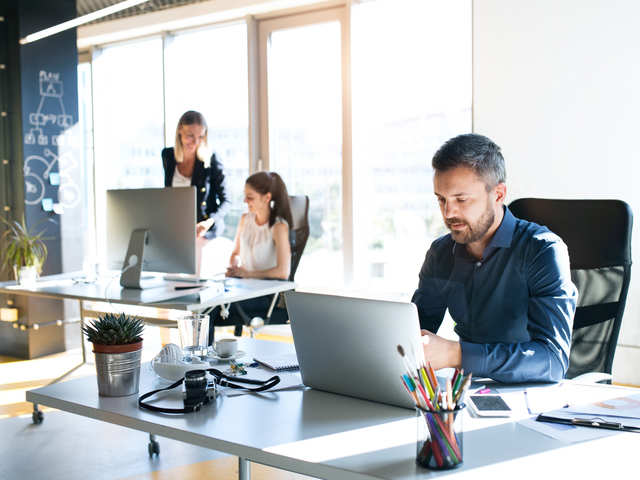

In [38]:
img = cv2.imread(imagefile)

In [39]:
height, width, _ = img.shape
blob = cv2.dnn.blobFromImage(img, 1/255, (416, 416), (0, 0, 0), swapRB = True, crop=False)

net.setInput(blob)

output_layers_names = net.getUnconnectedOutLayersNames()
layerOutputs = net.forward(output_layers_names)

In [40]:
boxes=[]
confidences=[]
class_ids=[]

for output in layerOutputs:
  for detection in output:
    scores=detection[5:]
    class_id=np.argmax(scores)
    confidence=scores[class_id]

    if confidence > 0.5:
      x, y, w, h = detection[0]*width, detection[1]*height, detection[0]*width, detection[3]*height
      boxes.append([int(x), int(y), int(w), int(h)])
      confidences.append(float(confidence))
      class_ids.append(class_id)

In [41]:
results=list(zip(boxes, confidences, class_ids))

indicies = cv2.dnn.NMSBoxes(boxes, confidences, 0.5, 0.4)
final_results = np.array(results)[indicies.flatten()].tolist()

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:5: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  """


[[[489, 266, 489, 263], 0.997805118560791, 0],
 [[370, 345, 370, 112], 0.9936268925666809, 63],
 [[192, 191, 192, 168], 0.9819258451461792, 0],
 [[258, 250, 258, 165], 0.970781683921814, 0],
 [[116, 353, 116, 87], 0.9682043790817261, 58],
 [[153, 227, 153, 80], 0.9059092998504639, 63],
 [[584, 420, 584, 20], 0.7859687209129333, 67],
 [[27, 249, 27, 79], 0.6718932390213013, 58]]

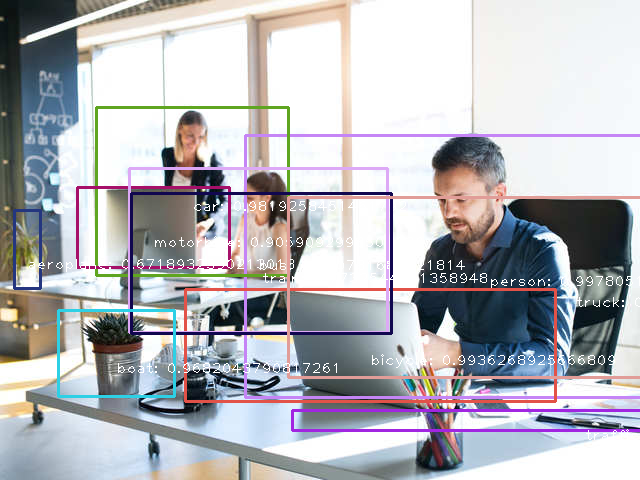

In [42]:
newimg=img.copy()

font = cv2.FONT_HERSHEY_PLAIN
colors=np.random.uniform(0, 255, size=(len(boxes), 3))

for i, ((x, y, w, h), confidence, class_id) in enumerate(results):
  cv2.rectangle(newimg, (x-w//2, y-h//2), (x+w//2, y+h//2), colors[i], 2)
  cv2.putText(newimg, classlabels[i]+": "+str(confidence), (x, y+20), font, 1, (255, 255, 255), 1)

cv2_imshow(newimg)